<a href="https://colab.research.google.com/github/EmanuelAlogna/MRI-generation/blob/master/src/Load_%26_testing_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time
import math

print(tf.__version__)

from google.colab import drive
drive.mount('/content/drive')

TensorFlow 2.x selected.
2.0.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Loading the val and test sets

In [0]:
def get_feature_description(modalities):                                                   
                                                                                           
    feature_description =lambda mod : {                                                    
                            mod+'_mri': tf.io.FixedLenFeature([], tf.string),              
                            mod+'_path': tf.io.FixedLenFeature([], tf.string),             
                                                                                           
                            mod+'_mri_min': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_min_src': tf.io.FixedLenFeature([], tf.float32),     
                            mod+'_mri_max': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_max_src': tf.io.FixedLenFeature([], tf.float32),     
                                                                                           
                            mod+'_mri_lperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_mri_lperc_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_x_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_y_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_x_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_y_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                                                                                           
                            mod+'_x_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_y_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_z_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                                                                                           
                            mod+'_z_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_x_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_y_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_patient': tf.io.FixedLenFeature([], tf.string),          
                            mod+'_sample_number': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_grade': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_location': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_version': tf.io.FixedLenFeature([], tf.string),  
                            mod+'_dataset_name': tf.io.FixedLenFeature([], tf.string),     
                            mod+'_mri_type': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_split': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_mri_seq': tf.io.FixedLenFeature([], tf.string),  
                          }                                                                
    features = {}                                                                          
    for mod in modalities:
        features.update(feature_description(mod))
    return features

In [0]:
#BUFFER_SIZE = 400
BATCH_SIZE = 32

In [0]:
use_gzip_compression = True

def load_dataset(name, mri_type, center_crop=None, random_crop=None, filter=None, batch_size=BATCH_SIZE, cache=True, 
                 prefetch_buffer=1, shuffle_buffer=128, interleave=1, cast_to=tf.float32, clip_labels_to=0.0, 
                 take_only=None, shuffle=True, infinite=False, n_threads=os.cpu_count()):
    def parse_sample(sample_proto):
        parsed = tf.io.parse_single_example(sample_proto, get_feature_description(["OT"]+mri_type))
        # Decoding image arrays
        
        slice_shape = [parsed['OT_x_dimension'.format(mri_type[0])], parsed['OT_y_dimension'], 1]
        # Decoding the ground truth
        parsed['seg'] = tf.cast(tf.reshape(tf.io.decode_raw(parsed['OT_mri'], tf.float32), shape=slice_shape), dtype=cast_to)
        # Decode each channel and stack in a 3d volume
        stacked_mri = list()
        for mod in mri_type:
            stacked_mri.append(tf.cast(tf.reshape(tf.io.decode_raw(parsed['{}_mri'.format(mod)], tf.float32), shape=slice_shape), dtype=cast_to))
        parsed['mri'] = tf.concat(stacked_mri, axis=-1)
        # Clipping the labels if requested
        parsed['seg'] = tf.clip_by_value(parsed['seg'], 0.0, clip_labels_to) if clip_labels_to else parsed['seg']
        
        # Cropping
        if random_crop or center_crop:
            # Stacking the mri and the label to align the crop shape
            mri_seg = tf.concat([parsed['mri'], parsed['seg']], axis=-1)
            if random_crop:
                random_crop[-1] = mri_seg.shape[-1] 
                cropped = tf.image.random_crop(mri_seg, size=random_crop)
            else:
                cropped = tf.image.resize_with_crop_or_pad(mri_seg,center_crop[0],center_crop[1])
            # Splitting back
            parsed['mri'] = cropped[:,:,:len(mri_type)]
            parsed['seg'] = cropped[:,:,len(mri_type):]
        
        return parsed
    
    path = './drive/My Drive/MRI-generation/{}.tfrecords'.format(name)
    dataset = tf.data.TFRecordDataset(path, compression_type='GZIP' if use_gzip_compression else "")
    dataset = dataset.filter(filter) if filter is not None else dataset
    dataset = dataset.take(take_only) if take_only is not None else dataset

    # You should generally cache after loading and preprocessing the data, 
    # but before shuffling, repeating, batching and prefetching”
    dataset = dataset.cache() if cache else dataset
    if shuffle and infinite:
        dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(shuffle_buffer))
    else:
        dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=True) if shuffle else dataset
        dataset = dataset.repeat() if infinite else dataset
    dataset = dataset.map(parse_sample, num_parallel_calls=None)
    dataset = dataset.batch(batch_size) if batch_size > 0 else dataset
    
    

    if interleave > 1:
        dataset = dataset.interleave(lambda x: tf.data.Dataset.from_tensors(x).repeat(interleave), cycle_length=n_threads, block_length=interleave, num_parallel_calls=n_threads)
  
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
# Loading only validation and testing (no need to load the training)

def load_datasets():
    validation = load_dataset('brats2015_validation_crop_mri', ['MR_T1', 'MR_T2'])
    testing = load_dataset('brats2015_testing_crop_mri', ['MR_T1', 'MR_T2'])
    return validation , testing

In [0]:
validation, testing = load_datasets() # I'll use this in case I get stuck with the cache.

In [0]:
# PROCESSING IMAGES IN THE BATCH
def process_batch(batch):   # takes in input a raw_record[mod].numpy()
    batch = tf.io.decode_raw(batch, tf.float32)
    batch = tf.reshape(batch, (BATCH_SIZE, 180, 180))
    paddings = tf.constant([[0, 0], [38, 38], [38, 38]])
    batch = tf.pad(batch, paddings, "CONSTANT")
    batch = tf.expand_dims(batch, axis=3)
    return batch
    
# final shape will be (bs, 256, 256, 1): now the batch is ready to be fed to the GAN

In [0]:
# this function preprocesses the input image and the ground truth from a raw_record
# images in the return are then ready to be fed into the GAN
def take_images_from_raw(raw_record):

    inp, ground_truth = raw_record[modalities[0]], raw_record[modalities[1]]
    inp = process_batch(inp)
    ground_truth = process_batch(ground_truth)
    return inp, ground_truth

(32, 256, 256, 1) (32, 256, 256, 1)
Batch with a size of 32 and dimension of (256,256) per image


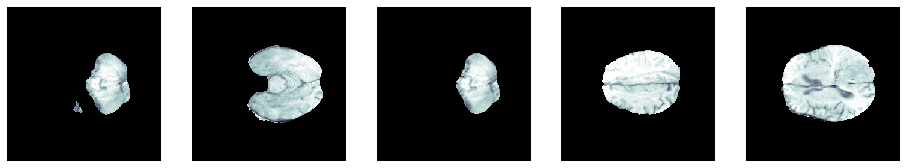

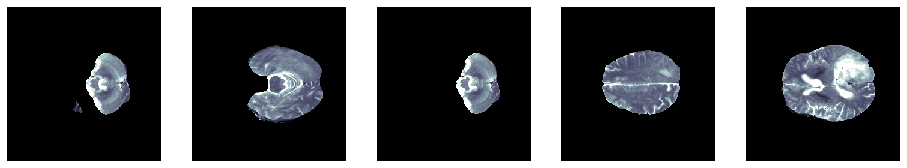

In [9]:
modalities = ['MR_T1_mri', 'MR_T2_mri']

for raw_record in validation.take(1):
    inp, ground_truth = take_images_from_raw(raw_record)

    print(inp.shape, ground_truth.shape)

    plt.figure(1 , figsize = (16, 8))
    print("Batch with a size of {} and dimension of (256,256) per image".format(BATCH_SIZE))
    n = 0 
    for i in range(5):     # batch size is different from 10, but let's show just 10 images 
    # to see all the images belonging to the batch, just change 10 with 'BATCH_SIZE'
        n += 1
        plt.subplot(2 , 5 , n)
        img = inp[i]
        plt.imshow(tf.squeeze(img), cmap='bone')
        plt.axis('off')

    n = 0 
    plt.figure(2 , figsize = (16, 8))
    for i in range(5):    
        n += 1
        plt.subplot(2 , 5 , n)
        img = ground_truth[i]
        plt.imshow(tf.squeeze(img), cmap='bone')
        plt.axis('off')

## Load some useful functions

In [0]:
def rescale(x, xmin, xmax, a, b):
    return (a + (b-a)*(x-xmin)/(xmax-xmin))  
    # to rescale in the range [0, 1], 'a' must be 0 and 'b' = 1

In [0]:
@tf.function
def normalize(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])
        x = rescale(image[i], min_value, max_value, 0, 1)
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized

In [0]:
def resize_with_crop(image_input, image_ground_truth, image_prediction):
    # FROM THE PAPER: 
    # "In order to crop out the brain region from each sequence, we calculate the largest bounding box that 
    # can accommodate each brain in the whole dataset, and then use the coordinates to crop each sequence in every patient scan. 
    # The final cropped size of a single patient scan with all sequences contains 148 axial slices of size 194 × 155."

    # I use this size in order to have similar results to the ones reached by the paper.

    image_input = tf.image.resize_with_crop_or_pad(image_input, 155, 194)
    image_ground_truth = tf.image.resize_with_crop_or_pad(image_ground_truth, 155, 194)
    image_prediction = tf.image.resize_with_crop_or_pad(image_prediction, 155, 194)

    return image_input, image_ground_truth, image_prediction

In [0]:
def plot_images(inp, ground_truth, prediction):
    display_list = [inp, ground_truth, prediction]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    plt.figure(1 , figsize = (16 , 8))
    n = 0
    for i in range(3):
        for j in range(5):  # batch size is different from 10, but let's show just 10 images.
            n += 1
            plt.subplot(3, 5, n).title.set_text(title[i])
            plt.imshow(tf.squeeze(display_list[i][j]), cmap='bone')
            plt.axis('off')
    plt.show()
    print()

In [0]:
def plot_whole_batch(inp, ground_truth, prediction):
    display_list = [inp, ground_truth, prediction]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    plt.figure(1 , figsize = (60 , 10))
    n = 0
    for i in range(3):
        for j in range(BATCH_SIZE):  # batch size is different from 10, but let's show just 10 images.
            n += 1
            plt.subplot(3, BATCH_SIZE, n).title.set_text(title[i])
            plt.imshow(tf.squeeze(display_list[i][j]), cmap='bone')
            plt.axis('off')
    plt.show()
    print()

In [0]:
def evaluate_GAN(model, dataset, set_type):
    num_batches = 0                 # CAREFUL when batch_size is modified!!!
    if set_type == 'test':
        num_batches = 112           # in the test set, with batch 32, there are 112 elements.
    elif set_type == 'validation':
        num_batches = 108
    container_psnr = tf.TensorArray(tf.float32, size=num_batches)     
    container_mse = tf.TensorArray(tf.float32, size=num_batches)
    container_ssim = tf.TensorArray(tf.float32, size=num_batches)
    for idx, raw_record in dataset.enumerate():
        
        inp, ground_truth = take_images_from_raw(raw_record)

        # generate the prediction        
        prediction = model(inp, training=False)

        # crop the images
        inp_cr, ground_truth_cr, prediction_cr = resize_with_crop(inp, ground_truth, prediction)
        if idx == 0:
            prediction = plot_images(inp_cr, ground_truth_cr, prediction_cr)
        
        # normalize the prediction
        prediction_normalized_cr = normalize(prediction_cr)

        # compute the metrics of similarity
        mean, std, psnr = compute_psnr(ground_truth_cr, prediction_normalized_cr)
        container_psnr = container_psnr.write(idx, psnr)

        mean, std, mse = compute_mse(ground_truth_cr, prediction_normalized_cr)
        container_mse = container_mse.write(idx, mse)

        mean, std, ssim = compute_ssim(ground_truth_cr, prediction_normalized_cr)
        container_ssim = container_ssim.write(idx, ssim)

    container_psnr = container_psnr.stack()
    container_mse = container_mse.stack()
    container_ssim = container_ssim.stack()
    mean_psnr = tf.reduce_mean(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    std_psnr = tf.math.reduce_std(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    mean_mse = tf.reduce_mean(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    std_mse = tf.math.reduce_std(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    mean_ssim = tf.reduce_mean(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))
    std_ssim = tf.math.reduce_std(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))

    print("PSNR on {} set: {} ± {}".format(set_type, (f'{mean_psnr:.4f}'), (f'{std_psnr:.4f}')))
    print("MSE on {} set: {} ± {}".format(set_type, (f'{mean_mse:.4f}'), (f'{std_mse:.4f}')))
    print("SSIM on {} set: {} ± {}".format(set_type, (f'{mean_ssim:.4f}'), (f'{std_ssim:.4f}')))
    #return mean_psnr, std_psnr, mean_mse, std_mse, mean_ssim, std_ssim

##Defining all the quantitative metrics (PSNR, SSIM and MSE)

In [0]:
def compute_psnr(image1, image2):
    # Compute PSNR over tf.float32 Tensors.
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    psnr = tf.image.psnr(im1, im2, max_val=1.0)
    mean = tf.reduce_mean(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    std = tf.math.reduce_std(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    # In the computation of mean and std, I'm ignoring the 'nan' and 'inf' values
    # Why 'nan' values? 'nan' happens when there is an image with max_value and min_value = 0.0 so a black image
    # the PSNR would be inf (image is totally similar to the ground truth)
    # be rescaling the image, the max_value and min_value would become nan and so the PSNR

    # It ignores also the 'inf' values, in the case I don't want to normalize
    
    return mean, std, psnr

In [0]:
def compute_ssim(image1, image2):
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    ssim = tf.image.ssim(im1, im2, max_val=1)
    mean = tf.reduce_mean(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    std = tf.math.reduce_std(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    #print(ssim)
    return mean, std, ssim

In [0]:
# I want to compute, first thing, the MSE between ground truth and generated one. The tf.function gives me a Tensor 32x256x256:
# MSE is computed PIXEL per PIXEL, so per each of the 32 matrix 256x256, I average (1) the values of the 256x256 pixels obtaining
# an array of 32 elements, containing the MSEs of each image belonging to the batch. Then I can average (2) these 32 to have 
# I should not average the whole 32x256x256 in one step. The result would have same mean but slightly different std.
# I want first to obtain the MSE of each image... then I average across the batch only to have smth more accurate.

def compute_mse(image1, image2):       # mean squared error
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    mse = tf.metrics.mean_squared_error(im1,im2)
    # In this way is possible to do Variable item-assignment with tensors 
    mse_per_image = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        x = tf.reduce_mean(tf.boolean_mask((mse[i]), tf.math.is_finite(mse[i]))) 
        mse_per_image = mse_per_image.write(i, x)
    mse_per_image = mse_per_image.stack()
    mean = tf.reduce_mean(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    std = tf.math.reduce_std(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    return mean, std, mse_per_image

## Load the model

I'll first load the model that in format 'h5'. Then test this model.

After this, I'll recover the generator, discriminator and optimizer states and test it. 
They should lead to the same results in the test set

In [0]:
# Let's load the models that I saved

# Recreate the exact same model, including its weights and the optimizer
gen = tf.keras.models.load_model('drive/My Drive/MRI-generation/gen_test1.h5', compile=False)
# with compile = False, the warning it goes away. I don't want to fit the model, just to test it

# I don't really need to save and load the discriminator model
disc = tf.keras.models.load_model('drive/My Drive/MRI-generation/disc_test1.h5', compile=False)


## Evaluate performances of the model

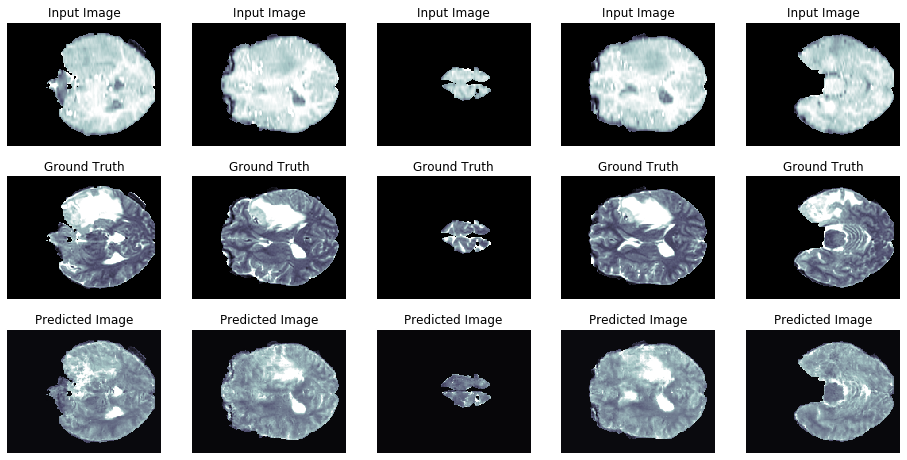


PSNR on test set: 20.5900 ± 3.5719
MSE on test set: 0.0118 ± 0.0099
SSIM on test set: 0.3366 ± 0.1276


In [20]:
# Let's check the scores of this model.

evaluate_GAN(gen, testing, 'test')

## Defining models and optimizers

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 1

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [0]:
# hint from the web: Unfortunately, UNet does not work with arbitrary input sizes. Try ResNet instead.

def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,1], batch_size=BATCH_SIZE)

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]
  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                         kernel_initializer=initializer,activation='tanh') # (bs, 256, 256, 1)
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
generator = Generator()

In [0]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image', batch_size=BATCH_SIZE)
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image', batch_size=BATCH_SIZE)

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) #(bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [0]:
discriminator = Discriminator()

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [29]:
generator_optimizer.weights

[]

## Let's load now the generator, discriminator weights and optimizers status from the checkpoints

In [30]:
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))

checkpoint_path = "./drive/My Drive/checkpoints/train"

ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))

Optimizers and models defined but not initialized? True
Latest checkpoint restored!!
Optimizers and models defined but not initialized? False


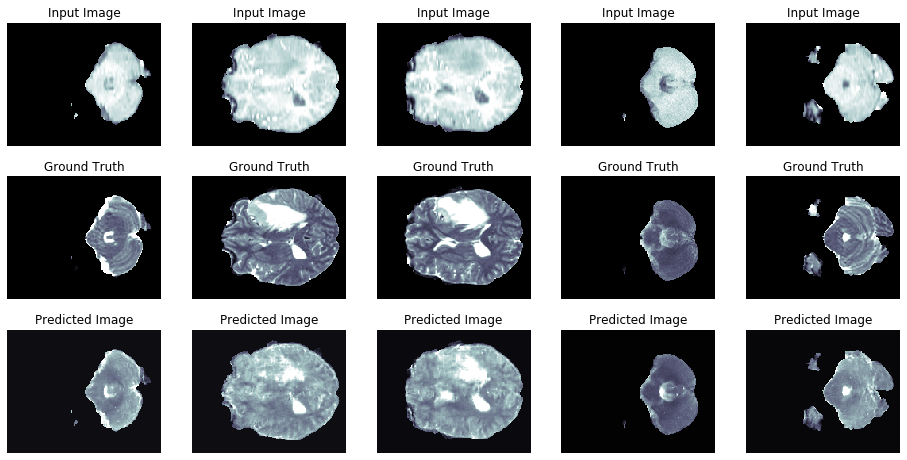


PSNR on test set: 20.5900 ± 3.5719
MSE on test set: 0.0118 ± 0.0099
SSIM on test set: 0.3366 ± 0.1276


In [31]:
# Let's check the scores of this model.

evaluate_GAN(generator, testing, 'test')

## Testing range values of prediction and evaluate model after the normalization of the predictions

In [0]:
def plot_whole_batch(inp, ground_truth, prediction):
    display_list = [inp, ground_truth, prediction]
    title = ['Input', 'GT', 'Predicted']

    for i in range(3):
        plt.figure(i , figsize = (60 , 10))
        n = 0
        for j in range(BATCH_SIZE):  # batch size is different from 10, but let's show just 10 images.
            n += 1
            plt.subplot(1, BATCH_SIZE, n).title.set_text(title[i])
            plt.imshow(tf.squeeze(display_list[i][j]), cmap='bone')
            plt.axis('off')
    plt.show()
    print()

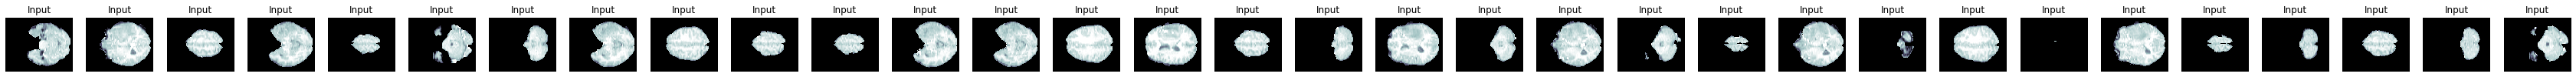

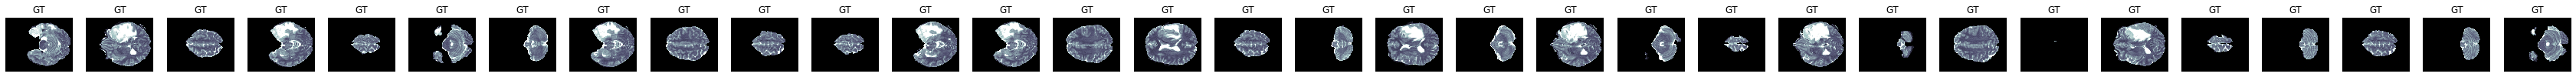

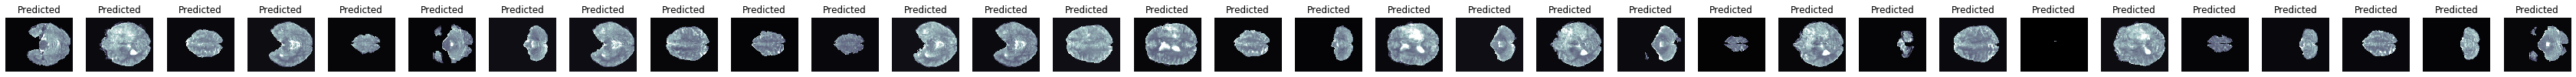


PSNR norm: 21.6909 ± 5.1715
tf.Tensor(
[19.565544 17.57523  20.795628 18.100958 24.70474  21.37397  20.787878
 18.188156 20.626102 24.888649 23.69181  17.226707 18.307123 17.20467
 18.714764 21.903954 24.870111 18.322968 20.988762 17.937824 22.146233
 24.805346 17.588089 25.003967 19.932898 46.546604 17.554901 23.921314
 23.531937 22.31673  23.142387 21.84154 ], shape=(32,), dtype=float32)
PSNR: 22.5455 ± 4.6928
tf.Tensor(
[19.740215 18.1839   22.291403 18.738802 24.47864  21.572998 23.692726
 19.014742 21.53322  25.657972 24.892181 18.246677 18.702097 18.787954
 19.34679  22.815884 25.405542 19.146706 23.887363 18.422148 24.382303
 24.716124 17.867155 25.924349 21.340252 43.908413 18.46662  24.09934
 25.81298  24.051687 23.602983 22.725245], shape=(32,), dtype=float32)

SSIM norm: 0.2398 ± 0.1453
tf.Tensor(
[0.24909356 0.24535778 0.17478348 0.2289703  0.16756828 0.26194087
 0.12451672 0.21701567 0.24977815 0.24820822 0.11780334 0.20195268
 0.23778759 0.24290638 0.34937745 0.20167163 

In [53]:
# Test to see if generated images are in the [0, 1] range: [-0.19628349 0.98358136]
# Still the PSNR normalized is 21.53, the one not normalized is 16.61
# What should I do?

# range of predictions after 35 epochs of training, let's see two examples:
# [-0.0327  0.9999] normalized in [0.0  1.0]
# [-0.0525  1.0000] normalized in [0.0  1.0]


for raw_record in testing.take(1):
    inp, ground_truth = take_images_from_raw(raw_record)

    prediction = gen(inp, training=False)
    inp, ground_truth, prediction = resize_with_crop(inp, ground_truth, prediction)
    plot_whole_batch(inp, ground_truth, prediction)
    prediction_normalized = normalize(prediction)

    """
    for i in range (BATCH_SIZE):
        max_value_image2 = np.amax(prediction[i])
        min_value_image2 = np.amin(prediction[i])
        max_value_image1 = np.amax(prediction_normalized[i])
        min_value_image1 = np.amin(prediction_normalized[i])
        print(i, min_value_image2, max_value_image2, min_value_image1, max_value_image1)
        """

    # note that there are errors in the ssim and mse when using the not-normalized versions. This because in the
    # normalized version I can ignore easily the nan values due to black images.
    # with ssim I can't do this, cause black images will have a ssim of value 1

    # so PSNR and MSE are pretty similar to the results of the paper. normalizing or not.
    # NOTE: I'm normalizing the images only before evaluation. Images coming in the discriminator are NOT normalized.
    # the SSIM normalized is very similar to result from the paper and it's very far from the not normalized result.

    mean, std, psnr = compute_psnr(ground_truth, prediction_normalized)
    print("PSNR norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    print(psnr)
    mean, std, psnr = compute_psnr(ground_truth, prediction)
    print("PSNR: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    print(psnr)
    print()
    mean, std, ssim = compute_ssim(ground_truth, prediction_normalized)
    print("SSIM norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    print(ssim)
    mean, std, ssim = compute_ssim(ground_truth, prediction)
    print("SSIM: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    print(ssim)
    print()
    mean, std, mse = compute_mse(ground_truth, prediction_normalized)
    print("MSE norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    print(mse)
    mean, std, mse = compute_mse(ground_truth, prediction)
    print("MSE: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    print(mse)